# Analyse Portfolio Performance

In [1]:
import ffn 
from empyrical import alpha_beta
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import discrete_allocation
import matplotlib as pyplot
import numpy as np
import pandas as pd

%matplotlib inline

import datetime as dt
#from datetime import datetime
from datetime import datetime, timedelta 
date = dt.datetime.now()
modified_date = date - timedelta(days=1)
e_= dt.datetime.strftime(modified_date, "%Y-%m-%d")
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import warnings
plt.style.use('dark_background')
warnings.simplefilter(action='ignore', category=FutureWarning)

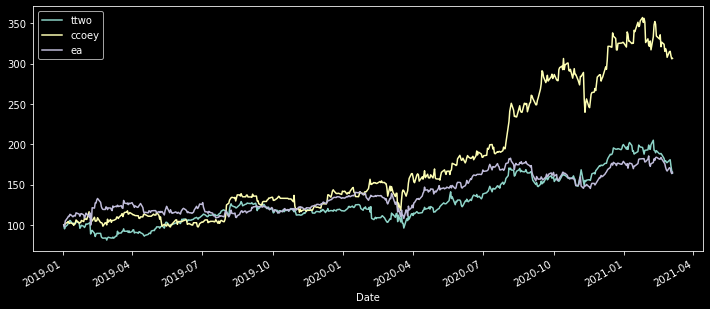

In [3]:
prices = ffn.get('TTWO, CCOEY, EA', start='2019-01-01')
benchmark = ffn.get('spy', start='2019-01-01')
ax = prices.rebase().plot(figsize=(12,5))
#plt.savefig(('Portfolio.png'), dpi=300)

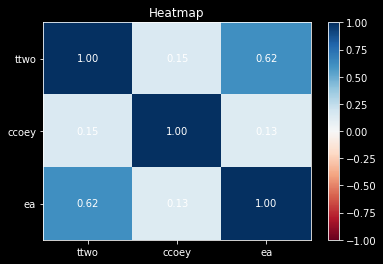

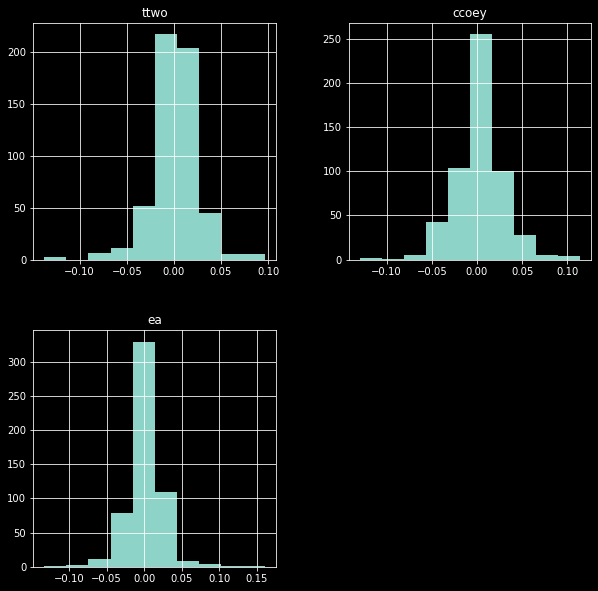

In [4]:
returns = prices.to_returns().dropna()
ffn.plot_corr_heatmap(returns)
ax = returns.hist(figsize=(10,10))
#plt.savefig(('Portfolio_return.png'), dpi=300)

In [5]:
stats = prices.calc_stats()
stats.display()

Stat                 ttwo        ccoey       ea
-------------------  ----------  ----------  ----------
Start                2019-01-02  2019-01-02  2019-01-02
End                  2021-03-05  2021-03-05  2021-03-05
Risk-free rate       0.00%       0.00%       0.00%

Total Return         64.22%      206.50%     65.41%
Daily Sharpe         0.80        1.42        0.82
Daily Sortino        1.21        2.42        1.39
CAGR                 25.67%      67.51%      26.09%
Max Drawdown         -25.38%     -24.68%     -23.39%
Calmar Ratio         1.01        2.74        1.12

MTD                  -7.40%      -0.43%      -0.90%
3m                   -5.49%      8.22%       3.17%
6m                   5.63%       19.28%      2.16%
YTD                  -17.80%     -6.08%      -7.55%
1Y                   45.66%      113.15%     20.63%
3Y (ann.)            25.67%      67.51%      26.09%
5Y (ann.)            -           -           -
10Y (ann.)           -           -           -
Since Incep. (ann.) 

what about the drawdowns?

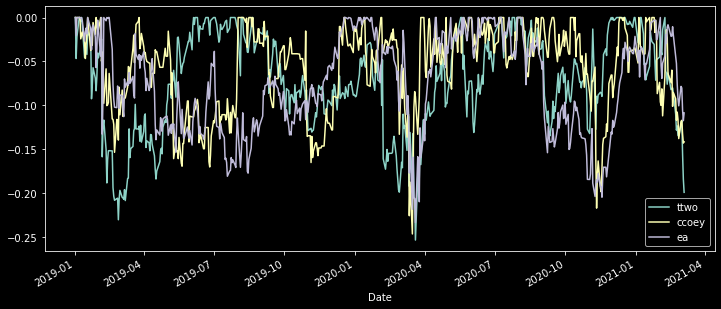

In [6]:
ax = stats.prices.to_drawdown_series().plot(figsize=(12,5))
#plt.savefig(('Portfolio_Drawdown.png'), dpi=300)

### Compound annual growth rate for a given price

In [7]:
stats.prices.calc_cagr()

ttwo     0.256693
ccoey    0.675123
ea       0.260869
dtype: float64

### Financial Functions

Determine the proper weights using a mean-variance approach 

In [8]:
returns=prices.to_log_returns().dropna()
returns.calc_mean_var_weights().as_format('.2%')

ttwo     14.27%
ccoey    62.49%
ea       23.24%
dtype: object

Determine the weights using a equally weighted approach

In [9]:
returns.calc_erc_weights().as_format('.2%')

ttwo     31.99%
ccoey    34.19%
ea       33.82%
Name: erc, dtype: object


David Varadi’s Fast Threshold Clustering Algorithm (FTCA)

In [10]:
returns.calc_ftca(threshold=0.8)

{1: ['ttwo'], 2: ['ccoey'], 3: ['ea']}

Calculate the beta of each stock

In [11]:
symbols = ['ttwo', 'ccoey', 'ea']

for sym in symbols:
    stk = ffn.get(sym, start='2016-01-01')
    alpha, beta = alpha_beta(stk, benchmark)
    print(sym, beta)

ttwo 0.7591809366709446
ccoey 0.1787048227001103
ea 0.40943383031272446


# Portfolio Return & Efficient Frontier

We bought 3 stocks of ttwo, 3 stocks of ccoey, 5 stocks of ea. We need to calculate the right return depending on the weights. 

In [12]:
returns = prices.pct_change()
weight = np.array([3, 3, 5])
t = np.sum(weight)
weights = weight/t 
# mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
 
portfolio_return = round(np.sum(mean_daily_returns * weights) * 252,2)
portfolio_std_dev = round(np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252),2)

print("Expected annualised return: " + str(portfolio_return))
print("Volatility: " + str(portfolio_std_dev))

Expected annualised return: 0.38
Volatility: 0.28


### The Efficient Frontier

In [13]:
# Expected returns and sample covariance
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Optimise portfolio for maximum Sharpe Ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('ttwo', 0.10085), ('ccoey', 0.69745), ('ea', 0.2017)])
Expected annual return: 55.0%
Annual volatility: 33.0%
Sharpe Ratio: 1.61


(0.5495222094306988, 0.32960528231520075, 1.6065343543988413)

In [14]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
ef.efficient_return(target_return=0.2, market_neutral=True)

OrderedDict([('ttwo', -0.2455315013493355),
             ('ccoey', 0.4801731438960447),
             ('ea', -0.2346416425467092)])